베이스라인 데이터를 불러옵니다.

이후 베이스라인 성능 컬럼을 제거합니다.
- 추후 합칠 예정

In [31]:
import warnings
import pandas as pd
pd.set_option('display.max_columns', 10)
warnings.filterwarnings('ignore')

data = pd.read_csv('house_price_prepared.csv')
data.pop('Id')

pred_data = data.pop('PredSalePrice')

print(f'data shape = {data.shape}')
data.head(2)

data shape = (1460, 81)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,...,YrSold,SaleType,SaleCondition,SalePrice,IsTrain
0,60,RL,65.0,8450,Pave,...,2008,WD,Normal,12.247699,True
1,20,RL,80.0,9600,Pave,...,2007,WD,Normal,12.109016,True


타겟 분포가 비슷한지 확인합니다.

만약 분포가 다른 경우 샘플링으로 이를 해결할 수 있습니다.

pvalue = 0.55449


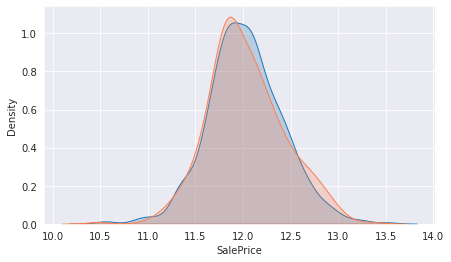

In [32]:
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(7, 4))

y_train = (
    data[data.IsTrain != False]
).SalePrice

y_test = (
    data[data.IsTrain == False]
).SalePrice

g = sns.kdeplot(data=y_train,shade=True)
g = sns.kdeplot(data=y_test, shade=True, color='coral')

pvalue = sp.stats.ks_2samp(
    y_train, y_test
).pvalue

print(f'pvalue = {pvalue:.5f}')
plt.show()

베이스라인과 같은 방식으로 중요도 기반 피처를 선택합니다.

In [33]:
from sklearn.feature_selection import SelectKBest, f_regression

x_data = pd.get_dummies(
    data, dummy_na=True
).dropna(axis=0)

y_data = x_data.pop('SalePrice')

selector = SelectKBest(f_regression, k=50)
selector.fit_transform(x_data, y_data)

selected_mask = selector.get_support()
all_feature = x_data.columns

selected_feature = all_feature[selected_mask]

feature = pd.DataFrame(
    [c.split('_') for c in selected_feature], 
    columns=['ImportantFeature', 'ImportantValue']
)
feature.T

,0,1,2,3,4,...,45,46,47,48,49
ImportantFeature,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,...,GarageType,GarageFinish,GarageFinish,SaleType,SaleCondition
ImportantValue,None,None,None,None,None,...,Detchd,Fin,Unf,New,Partial


중요도가 높은 피처 중에서 결측 빈도를 체크합니다.
- 파랑색은 중요한 피처를 의미하고 회색은 그렇지 않은 경우

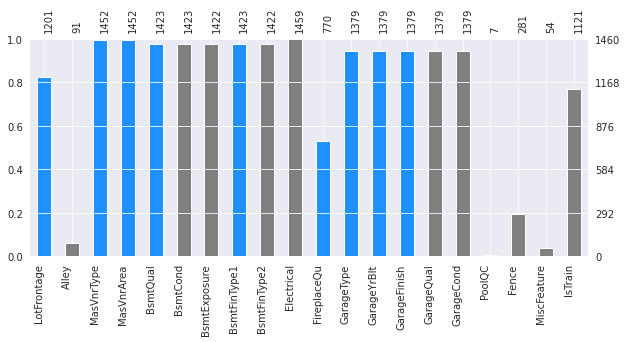

In [34]:
import missingno as msno

missing_mask = (
    data.isna().sum() != 0
).values

missing_feature = data.columns[missing_mask]

importance_feature = set(
    feature.ImportantFeature
)

importance_mask = ['gray'] * len(importance_feature)

for n, f in enumerate(missing_feature):
    if f not in importance_feature:
        continue
    importance_mask[n] = 'dodgerblue'

msno.bar(
    data[missing_feature],
    figsize=(10, 4), fontsize=10, label_rotation=90,
    color=importance_mask
)
plt.show()

결측값은 모델링에 방해 요소입니다.

따라서 결측치를 제거하거나 대체 또는 예측할 수 있습니다.

이번 스크립트에서 결측치 예측을 진행할 예정이며

먼저 연속형 변수에 대해 다루고 이후 카테고리 변수를 예측합니다.

연속형 변수 중에서 파랑색은 예측이 필요한 변수입니다.
- 노랑색은 결측치가 없으며 중요한 변수

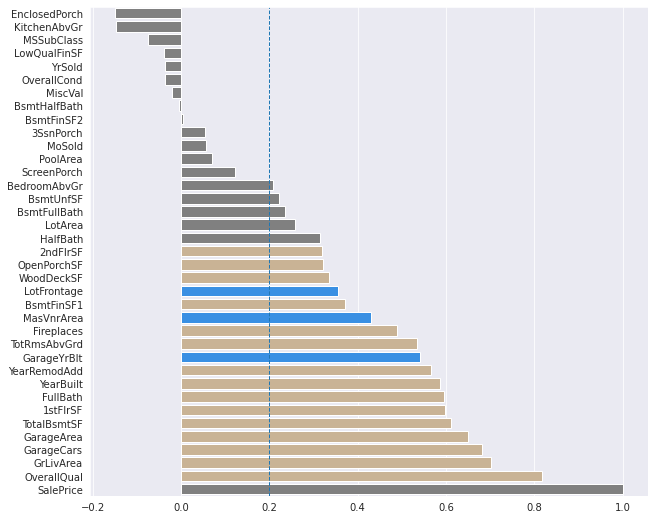

In [35]:
import numpy as np

plt.subplots(figsize=(10, 9))

correlated_feature = data.corr().SalePrice.sort_values()

correlated_missing_mask = [1 if f in missing_feature else 2 for f in correlated_feature.index]
correlated_importance_mask = [3 if f in importance_feature else 1 for f in correlated_feature.index]

correlated_mask = np.multiply(
    correlated_missing_mask,
    correlated_importance_mask
)

correlated_map = {
    1: 'gray',          # this low importance.
    2: 'gray',          #      missing value.
    3: 'dodgerblue',    #      high importance and missing value.
    6: 'tan'            #      high importance and nice.
}
correlated_mask = [correlated_map[f] for f in correlated_mask]

sns.barplot(
    x=correlated_feature.values,
    y=correlated_feature.index,
    orient='h',
    palette=correlated_mask
)
plt.axvline(x=0.2, linewidth=1, linestyle='--')
plt.show()

또한 연속형 변수의 분포를 체크합니다.

회귀 분석 성능을 높이기 위해 독립 또한 정규 분포에 근사시킬 수 있습니다.

정규 분포 근사에는 여러가지 방법이 존재하나 이번 장에서는 박스콬스 변환을 실시합니다.

In [36]:
from scipy.stats import skew

cat_feature = data.dtypes[data.dtypes == 'object'].index
num_feature = data.dtypes[data.dtypes != 'object'].index

def skewness_info(feature):
    skewed_feature = data[feature].apply(
        lambda x: skew(x.dropna())
    ).sort_values(ascending=False)

    skewness = skewed_feature.to_frame('Skew')
    return skewness

skewness = skewness_info(num_feature)

print(f'skewness = {skewness.shape}')
skewness.T

skewness = (37, 1)


,MiscVal,PoolArea,LotArea,3SsnPorch,LowQualFinSF,...,FullBath,GarageCars,YearRemodAdd,YearBuilt,GarageYrBlt
Skew,24.45164,14.813135,12.195142,10.293752,9.00208,...,0.036524,-0.342197,-0.503044,-0.612831,-0.648708


정규 분포 판별에는 왜도와 첨도가 존재합니다.

이에 우리는 왜도를 변경합니다.

왜도(Skew)는 데이터가 한쪽으로 치우친 정도를 나타냅나다.

박스콕스 변환에는 람다 변수가 필요합니다.
- 람다는 로그, 제곱근 등의 멱함수 파라미터

따라서 박스콕스 함수로 람다를 먼저 찾습니다.

In [37]:
from scipy.stats import boxcox

# this function is make a pipeline 1.1.

skewness = skewness[abs(skewness.Skew) >= 0.75]
skewed_feature = skewness.index
print(f'skwness count = {len(skewed_feature)}')

skewed_lambda = {
    f: [boxcox(
        data[data[f] > 0][f])[1]
    ] for f in skewed_feature
}
pd.DataFrame(skewed_lambda)

skwness count = 21


,MiscVal,PoolArea,LotArea,3SsnPorch,LowQualFinSF,...,MSSubClass,1stFlrSF,GrLivArea,BsmtUnfSF,2ndFlrSF
0,-0.200839,-2.890429,0.030946,0.51317,0.956013,...,-0.210841,-0.078832,0.006305,0.342103,0.525671


이제 실질적인 박스콕스 변환을 실시합니다.

변환된 데이터의 분포를 다시 확인하면 왜도가 줄어들었음을 확인할 수 있습니다.

In [40]:
from scipy.special import boxcox1p

# this function is make a pipeline 1.2.

# lam = 0.15

for n, f in enumerate(skewed_feature):
    data[f] = boxcox1p(data[f], skewed_lambda[f])
    
print(f'boxcox transformed count = {n}')

skewness = skewness_info(num_feature)
skewness.T

boxcox transformed count = 20


,PoolArea,LowQualFinSF,3SsnPorch,MiscVal,BsmtHalfBath,...,YearBuilt,GarageYrBlt,BsmtUnfSF,TotalBsmtSF,KitchenAbvGr
Skew,14.33793,8.859702,7.913599,5.017357,3.855436,...,-0.612831,-0.648708,-1.946278,-5.568634,-38.170678


위에서 중요한 피처 중에서 결측이 존재하는 세가지가 있었습니다.

즉 해당 변수의 결측을 처리하기 위해서는 관련이 높은 변수를 택할 필요가 있습니다.

우리는 어떤 변수가 상관 관계가 있는지 확인합니다.

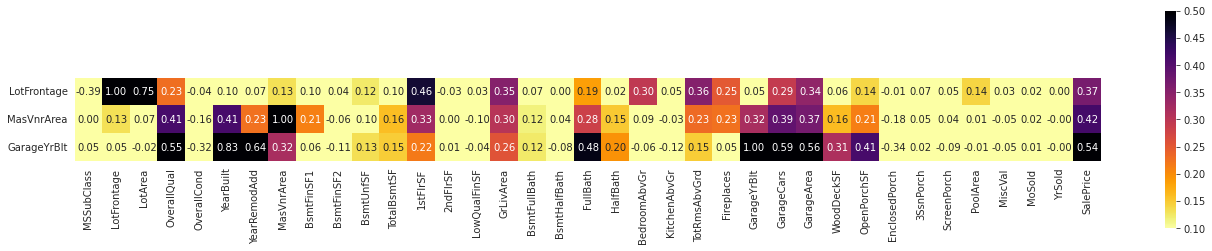

In [41]:
plt.subplots(figsize=(23, 4))

threshold = len(data) * 0.7

imputed_feature = (
    data[missing_feature].isna().sum()
).to_frame('Isna')

imputed_feature = (
    imputed_feature[imputed_feature.Isna <= threshold]
).index

correlation = data.corr()

sns.heatmap(
    correlation.filter(imputed_feature).T,
    cbar=True, annot=True, square=True, fmt='.2f',
    cmap='inferno_r', vmin=0.1, vmax=0.5
)
plt.show()

관계가 있는 변수를 바탕으로 결측치 예측을 진행합니다.

해당 라이브러리를 사용하면 예측이 필요한 변수마다 

서로 다른 독립 변수를 활용할 수 있습니다.


In [ ]:
from autoimpute.imputations import SingleImputer

prep_data = data.copy()

# this function is make a pipeline.

imputer = SingleImputer(
    strategy={
        'LotFrontage': 'pmm',
        'MasVnrArea': 'pmm', 
        'GarageYrBlt': 'pmm'
    },
    predictors={
        'LotFrontage': ['1stFlrSF', 'GrLivArea', 'LotArea'], 
        'MasVnrArea': ['OverallQual', 'GrLivArea', 'GarageArea'],
        'GarageYrBlt': ['YearBuilt', 'YearRemodAdd'],
        
    },
    seed=27
)

prep_data = imputer.fit_transform(prep_data)

이제 중요한 연속형 변수가 잘 채워진 것을 확인할 수 있습니다.

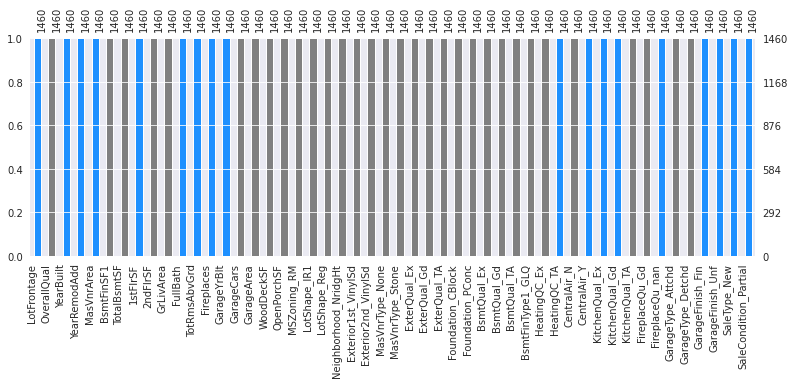

In [45]:
msno.bar(
    pd.get_dummies(
        prep_data, dummy_na=True
    ).filter(selected_feature),
    figsize=(13, 4), fontsize=10, label_rotation=90,
    color=importance_mask
)
plt.show()

이제 카테고리 변수 예측이 필요합니다.

위 결측 그래프에서 카테고리 변수 결측이 존재하지 않는 이유는

원핫 인코딩을 진행했기 때문입니다.

따라서 빈값이 어떤 의미를 가지고 있는지 확인할 필요가 있습니다.
- 새로운 데이터에서 빈값 존재 시 처리가 필요하기 때문

In [64]:
num_selected_feature = selected_feature & num_feature

clean_data = pd.concat([
    prep_data.filter(
        list(num_selected_feature) + list(cat_feature)),
    pred_data],
    axis=1
)
clean_data.to_csv('house_price_clean_num.csv', index=False, header=True)

print(f'clean data shape = {clean_data.shape}')
clean_data.head(2)

clean data shape = (1460, 63)


,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,...,MiscFeature,SaleType,SaleCondition,IsTrain,PredSalePrice
0,4.232750,7,2003,2003,3.592544,...,NaN,WD,Normal,True,NaN
1,4.485301,6,1976,1976,0.000000,...,NaN,WD,Normal,True,NaN
